# UM Dimensions.ai Publications and References

Uses Dimensions Analytics API to collect publications from University of Mississippi, and to collect references from those publications for analysis. 
Additional cells at the bottom allow the user to look up a particular journal (using a Dimensions journal ID number) and to calculate citation ages for each reference. 

A Dimensions Analytics API key is required. The script makes extensive use the Dimcli package, which has very thorough documentation here: https://digital-science.github.io/dimcli/getting-started.html

The Dimensions API Cookbooks contain tutorials and code snippets, several of which have been used here. In particular, the [Journals Cited by a Research Organization cookbook](https://api-lab.dimensions.ai/cookbooks/2-publications/Which-Are-the-Journals-Cited-By-My-Organization.html) was of great help. 

In [1]:
import json
import os
import sys
import time
import requests
import datetime
import dimcli
from dimcli.utils import *
from tqdm.notebook import tqdm
import pandas as pd
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
    
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))
print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
KEY = ""
dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
CHANGELOG
This notebook was last run on Jun 13, 2024
==
==
Logging in..
Dimcli - Dimensions API Client (v1.2)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.10
Method: dsl.ini file


## Get UM-authored publications for a date range

In [2]:
GRIDID = 'grid.251313.7' #@param {type:"string"}
# University of Mississippi organizational identifier (excludes UMMC)

YEAR_START = input("Enter the year at which to start the search: ") #@param {type: "slider", min: 1950, max: 2024}
YEAR_END = input("Enter the year at which to end the search: ") #@param {type: "slider", min: 1950, max: 2024}
YEAR_END = max(YEAR_END, YEAR_START)

Enter the year at which to start the search:  1985
Enter the year at which to end the search:  1985


In [3]:
### Initial lookup: all UM publications for the specified time period ###
publications = dsl.query_iterative(f"""

    search publications
        where research_orgs.id = "{GRIDID}"
        and year in [{YEAR_START}:{YEAR_END}]
        return publications[id+authors+reference_ids+year+funders+funding_section]

""")

Starting iteration with limit=1000 skip=0 ...
0-145 / 145 (5.38s)
===
Records extracted: 145
Warnings:  1


In [4]:
# This caused major headaches in testing. Make sure to drop na values from the data - they will stop the next query in its tracks
pubs_and_citations = publications.as_dataframe().explode("reference_ids")
df = pubs_and_citations.copy()
df = df.dropna(axis=0)
citations = df.copy()
citations.rename(columns={"year": "UM_year","id": "UM_publication_ID","authors": "UM_pub_authors"}, inplace=True)

In [5]:
pubs_and_citations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1660 entries, 0 to 144
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1660 non-null   object
 1   authors        1660 non-null   object
 2   year           1660 non-null   int64 
 3   reference_ids  1611 non-null   object
 4   funders        264 non-null    object
dtypes: int64(1), object(4)
memory usage: 77.8+ KB


## Get references for UM-authored publications

In [6]:
### Start the references query using the list of publications previously generated  ###

# get a list of citation IDs
pubids = list(set(citations['reference_ids']))  # use set() to remove duplicates


#
# DSL query - change the return statement to extract different metadata of interest
query_template = """search publications
                    where id in {}
                    return publications[id+doi+journal+year+publisher+type+issn]
                    limit 1000"""


#
# loop through all references-publications IDs in chunks and query Dimensions
print(f"===\nExtracting publications data for {len(pubids)} citations...")
results = []
BATCHSIZE = 400
VERBOSE = False # set to True to see extraction logs

for chunk in tqdm(list(chunks_of(pubids, BATCHSIZE))):
    query = query_template.format(json.dumps(chunk))
    data = dsl.query(query, verbose=VERBOSE)
    results += data.publications
    time.sleep(0.5)

#
# save the citing pub data into a dataframe, remove duplicates and save
pubs_cited = pd.DataFrame().from_dict(results)
print("===\nCited Publications found: ", len(pubs_cited))


#
# transform the 'journal' column because it contains nested data
temp = pubs_cited['journal'].apply(pd.Series).rename(columns={"id": "journal.id",
                                                              "title": "journal.title"}).drop([0], axis=1)
pubs_cited = pd.concat([pubs_cited.drop(['journal'], axis=1), temp], axis=1).sort_values('type')
pubs_cited.head(10)

pubs_cited = pubs_cited.merge(citations, left_on='id', right_on='reference_ids')

===
Extracting publications data for 250 citations...


  0%|          | 0/1 [00:00<?, ?it/s]

===
Cited Publications found:  250


In [7]:
pubs_cited.head(5)

,doi,id,issn,publisher,type,year,journal.id,journal.title,UM_publication_ID,UM_pub_authors,UM_year,reference_ids,funders
0,10.1182/blood.v64.4.763.763,pub.1121768074,"[0006-4971, 1528-0020]",American Society of Hematology,article,1984,jour.1085025,Blood,pub.1052956799,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1121768074,"[{'acronym': 'NIDDK', 'city_name': 'Bethesda',..."
1,10.1007/bf01611021,pub.1037844075,"[0007-4861, 1432-0800]",Springer Nature,article,1981,jour.1005778,Bulletin of Environmental Contamination and To...,pub.1040335484,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037844075,"[{'acronym': 'NIGMS', 'city_name': 'Bethesda',..."
2,10.1007/bf01611021,pub.1037844075,"[0007-4861, 1432-0800]",Springer Nature,article,1981,jour.1005778,Bulletin of Environmental Contamination and To...,pub.1013740626,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037844075,"[{'acronym': 'NIGMS', 'city_name': 'Bethesda',..."
3,10.1016/0014-4827(84)90784-5,pub.1037199487,"[0014-4827, 1090-2422]",Elsevier,article,1984,jour.1017523,Experimental Cell Research,pub.1052956799,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037199487,"[{'acronym': 'NIDDK', 'city_name': 'Bethesda',..."
4,10.1016/0014-4827(84)90784-5,pub.1037199487,"[0014-4827, 1090-2422]",Elsevier,article,1984,jour.1017523,Experimental Cell Research,pub.1005242960,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037199487,"[{'acronym': 'NIDDK', 'city_name': 'Bethesda',..."


## Add citation ages to the dataframe

In [8]:
# Handle NaN values in either of the year columns
pubs_cited.dropna(subset=['year', 'UM_year'], inplace = True)
pubs_cited.reset_index(inplace = True)  # reset the index - missing index values will cause issues later
pubs_cited.drop(['index'], axis = 1, inplace = True)  # drop the original index column

# Check the new dataframe
pubs_cited.info()
pubs_cited

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   doi                235 non-null    object
 1   id                 263 non-null    object
 2   issn               262 non-null    object
 3   publisher          234 non-null    object
 4   type               263 non-null    object
 5   year               263 non-null    int64 
 6   journal.id         256 non-null    object
 7   journal.title      256 non-null    object
 8   UM_publication_ID  263 non-null    object
 9   UM_pub_authors     263 non-null    object
 10  UM_year            263 non-null    int64 
 11  reference_ids      263 non-null    object
 12  funders            263 non-null    object
dtypes: int64(2), object(11)
memory usage: 26.8+ KB


,doi,id,issn,publisher,type,year,journal.id,journal.title,UM_publication_ID,UM_pub_authors,UM_year,reference_ids,funders
0,10.1182/blood.v64.4.763.763,pub.1121768074,"[0006-4971, 1528-0020]",American Society of Hematology,article,1984,jour.1085025,Blood,pub.1052956799,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1121768074,"[{'acronym': 'NIDDK', 'city_name': 'Bethesda',..."
1,10.1007/bf01611021,pub.1037844075,"[0007-4861, 1432-0800]",Springer Nature,article,1981,jour.1005778,Bulletin of Environmental Contamination and To...,pub.1040335484,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037844075,"[{'acronym': 'NIGMS', 'city_name': 'Bethesda',..."
2,10.1007/bf01611021,pub.1037844075,"[0007-4861, 1432-0800]",Springer Nature,article,1981,jour.1005778,Bulletin of Environmental Contamination and To...,pub.1013740626,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037844075,"[{'acronym': 'NIGMS', 'city_name': 'Bethesda',..."
3,10.1016/0014-4827(84)90784-5,pub.1037199487,"[0014-4827, 1090-2422]",Elsevier,article,1984,jour.1017523,Experimental Cell Research,pub.1052956799,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037199487,"[{'acronym': 'NIDDK', 'city_name': 'Bethesda',..."
4,10.1016/0014-4827(84)90784-5,pub.1037199487,"[0014-4827, 1090-2422]",Elsevier,article,1984,jour.1017523,Experimental Cell Research,pub.1005242960,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037199487,"[{'acronym': 'NIDDK', 'city_name': 'Bethesda',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,10.1016/b978-0-12-107607-8.50011-8,pub.1053143456,[0071-1446],Elsevier,chapter,1976,NaN,NaN,pub.1013740626,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1053143456,"[{'acronym': 'NIGMS', 'city_name': 'Bethesda',..."
259,10.1016/s0065-3233(08)60458-1,pub.1022309611,"[1876-1623, 1876-1631, 0065-3233]",Elsevier,chapter,1979,NaN,NaN,pub.1014167586,"[{'affiliations': [{'city': 'Birmingham', 'cit...",1985,pub.1022309611,"[{'acronym': 'NCI', 'city_name': 'Bethesda', '..."
260,10.1002/9780470122891.ch6,pub.1037564072,"[0065-258X, 1934-4694]",Wiley,chapter,1976,NaN,NaN,pub.1005242960,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037564072,"[{'acronym': 'NIDDK', 'city_name': 'Bethesda',..."
261,10.1002/9780470720745.ch1,pub.1001638912,"[1528-2511, 1935-4657]",Wiley,chapter,1982,NaN,NaN,pub.1002830050,"[{'affiliations': [{'city': 'Kansas City', 'ci...",1985,pub.1001638912,"[{'acronym': 'NIGMS', 'city_name': 'Bethesda',..."


In [9]:
# Make a list of citation ages by subtracting the citation year from the UM year
cycle = 0
citation_ages = []

for um_year in list(pubs_cited["UM_year"]):
    citation_age = int(um_year) - int(pubs_cited["year"][cycle])
    citation_ages.append(citation_age)
    cycle = cycle + 1

# Add the list of citation ages as a new column in the pubs_cited data
pubs_cited['citation_age'] = citation_ages
pubs_cited

,doi,id,issn,publisher,type,year,journal.id,journal.title,UM_publication_ID,UM_pub_authors,UM_year,reference_ids,funders,citation_age
0,10.1182/blood.v64.4.763.763,pub.1121768074,"[0006-4971, 1528-0020]",American Society of Hematology,article,1984,jour.1085025,Blood,pub.1052956799,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1121768074,"[{'acronym': 'NIDDK', 'city_name': 'Bethesda',...",1
1,10.1007/bf01611021,pub.1037844075,"[0007-4861, 1432-0800]",Springer Nature,article,1981,jour.1005778,Bulletin of Environmental Contamination and To...,pub.1040335484,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037844075,"[{'acronym': 'NIGMS', 'city_name': 'Bethesda',...",4
2,10.1007/bf01611021,pub.1037844075,"[0007-4861, 1432-0800]",Springer Nature,article,1981,jour.1005778,Bulletin of Environmental Contamination and To...,pub.1013740626,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037844075,"[{'acronym': 'NIGMS', 'city_name': 'Bethesda',...",4
3,10.1016/0014-4827(84)90784-5,pub.1037199487,"[0014-4827, 1090-2422]",Elsevier,article,1984,jour.1017523,Experimental Cell Research,pub.1052956799,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037199487,"[{'acronym': 'NIDDK', 'city_name': 'Bethesda',...",1
4,10.1016/0014-4827(84)90784-5,pub.1037199487,"[0014-4827, 1090-2422]",Elsevier,article,1984,jour.1017523,Experimental Cell Research,pub.1005242960,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037199487,"[{'acronym': 'NIDDK', 'city_name': 'Bethesda',...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,10.1016/b978-0-12-107607-8.50011-8,pub.1053143456,[0071-1446],Elsevier,chapter,1976,NaN,NaN,pub.1013740626,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1053143456,"[{'acronym': 'NIGMS', 'city_name': 'Bethesda',...",9
259,10.1016/s0065-3233(08)60458-1,pub.1022309611,"[1876-1623, 1876-1631, 0065-3233]",Elsevier,chapter,1979,NaN,NaN,pub.1014167586,"[{'affiliations': [{'city': 'Birmingham', 'cit...",1985,pub.1022309611,"[{'acronym': 'NCI', 'city_name': 'Bethesda', '...",6
260,10.1002/9780470122891.ch6,pub.1037564072,"[0065-258X, 1934-4694]",Wiley,chapter,1976,NaN,NaN,pub.1005242960,"[{'affiliations': [{'city': 'Oxford', 'city_id...",1985,pub.1037564072,"[{'acronym': 'NIDDK', 'city_name': 'Bethesda',...",9
261,10.1002/9780470720745.ch1,pub.1001638912,"[1528-2511, 1935-4657]",Wiley,chapter,1982,NaN,NaN,pub.1002830050,"[{'affiliations': [{'city': 'Kansas City', 'ci...",1985,pub.1001638912,"[{'acronym': 'NIGMS', 'city_name': 'Bethesda',...",3


## More info about journals and publishers

In [10]:
pubs_cited['journal.id'].describe()

count              256
unique             119
top       jour.1085025
freq                12
Name: journal.id, dtype: object

In [11]:
journals = pubs_cited.value_counts(['journal.title', 'publisher'])
journals = journals.to_frame().reset_index().rename(columns= {0: 'citations', 'journal.title' : 'title'})
journals.index.name = 'index'

#preview
journals.head(10)

,title,publisher,citations
index,,,
0,Blood,American Society of Hematology,12
1,Journal of Cell Biology,Rockefeller University Press,10
2,Biochimica et Biophysica Acta,Elsevier,9
3,The Journal of Clinical Endocrinology & Metabo...,The Endocrine Society,9
4,Journal of Medicinal Chemistry,American Chemical Society (ACS),8
5,Journal of Bacteriology,American Society for Microbiology,8
6,Journal of Ultrastructure Research,Elsevier,6
7,Nature,Springer Nature,6
8,Journal of Biological Chemistry,Elsevier,6


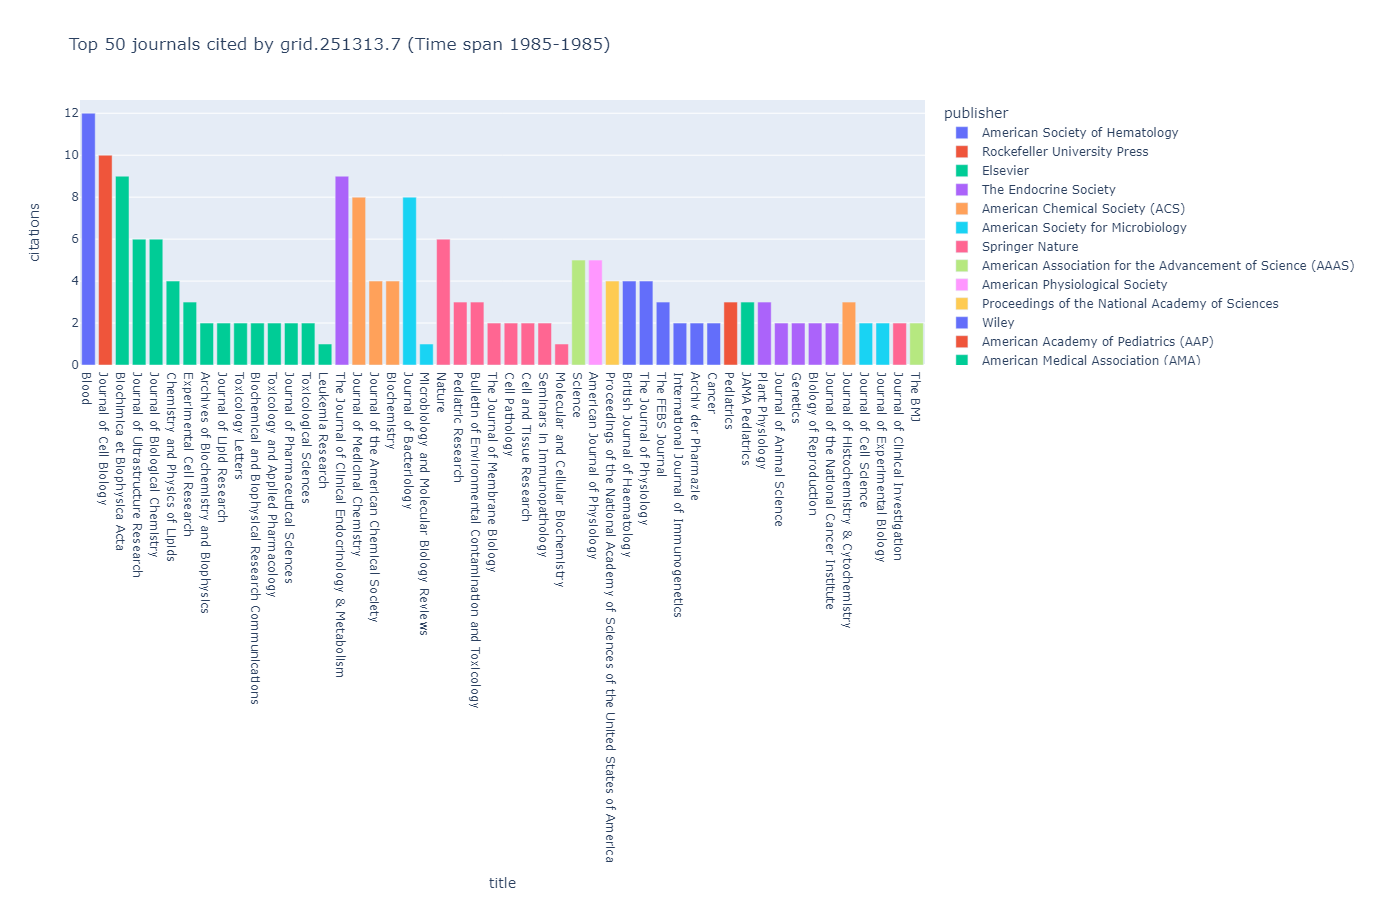

In [12]:
px.bar(journals[:50],
       x="title", y="citations", color="publisher",
       height=900,
       title=f"Top 50 journals cited by {GRIDID} (Time span {YEAR_START}-{YEAR_END})")

## Journal Lookup - Has Anyone Cited This Journal?

Search through the list of journal ids for the specified timeframe. If it matches a particular journal, pull the UM-affiliated authors

In [13]:
JOUR_ID_LOOKUP = "jour.1050134"

cited_count = 0
index = 0
um_authors = []
author_count = 0

for id in list(pubs_cited["journal.id"]):
    if id == JOUR_ID_LOOKUP:  # check if the journal appears in the overall citations list
        cited_count = cited_count + 1
        all_authors = pubs_cited["authors"][index]  # pull a list of the authors of the paper that cited the journal

        for author in all_authors:
            if author["affiliations"][0]["id"] == GRIDID:  # check if they are a UM author
                um_author = f'{author["first_name"]} {author["last_name"]}'
                um_affil = author["raw_affiliation"]
                if um_author not in um_authors:  # check if this author is already on the list
                    um_authors.append(um_author)  # if not, add them
                    um_authors.append(um_affil)  # and any departmental information they provided
                    author_count = author_count + 1
    
    index = index + 1

if cited_count > 0:
    print(f'Journal was cited in {cited_count} publications by {author_count} UM authors:',"\n")
    for author in um_authors:
        print(author, '\n')
else:
    print(f'This journal (journal id {JOUR_ID_LOOKUP}) was not cited by UM authors.')

This journal (journal id jour.1050134) was not cited by UM authors.


## Export the data to Excel

In [14]:
print(f'Do you want to generate an Excel file of all UM publications for {YEAR_START} to {YEAR_END}? Y/N')
excel_UM_pubs = input()
if excel_UM_pubs in ["Y", "y", "yes", "Yes"]:
    print("Saving Excel file...")
    pubs_and_citations.to_excel(f"UM_pubs_{YEAR_START}_to_{YEAR_END}.xlsx")
    print("File saved.", "\n")
else:
    print("No Excel file will be generated.", "\n")


print(f'Do you want to generate an Excel file of all references & citation ages in UM publications for {YEAR_START} to {YEAR_END}? Y/N', 
      "\n" ,"WARNING: This may be a very large file")
excel_UM_refs = input()
if excel_UM_refs in ["Y", "y", "yes", "Yes"]:
    print("Saving Excel file...")
    pubs_cited.to_excel(f"References_in_UM_pubs_{YEAR_START}_to_{YEAR_END}.xlsx")
    print("File saved.", "\n")
else:
    print("No Excel file will be generated.", "\n")

Do you want to generate an Excel file of all UM publications for 1985 to 1985? Y/N


 n


No Excel file will be generated. 

Do you want to generate an Excel file of all references & citation ages in UM publications for 1985 to 1985? Y/N 


 n


No Excel file will be generated. 

